In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline

# Create a Spark session
spark = SparkSession.builder.appName("Penguins Species Cluster Analysis").getOrCreate()

df = spark.read.csv("data/penguins_size.csv", header=True, inferSchema=True)
print(f'Initial DataFrame size: {df.count()} rows')

# Drop rows with NA strings and cast safely
df_clean = df.filter((col("culmen_length_mm").isNotNull()) & 
                     (col("culmen_depth_mm").isNotNull()) &
                     (col("culmen_length_mm") != "NA") &
                     (col("culmen_depth_mm") != "NA")) \
	.withColumn("culmen_length_mm", col("culmen_length_mm").cast("double")) \
	.withColumn("culmen_depth_mm", col("culmen_depth_mm").cast("double")) \
	.withColumn("flipper_length_mm", col("flipper_length_mm").cast("double")) \
	.withColumn("body_mass_g", col("body_mass_g").cast("double"))
df_clean = df_clean.filter(col("culmen_length_mm").isNotNull() 
								   & col("culmen_depth_mm").isNotNull() 
									& col("flipper_length_mm").isNotNull() 
									& col("body_mass_g").isNotNull())
# df_clean.cache()
print(f'Cleaned DataFrame size: {df_clean.count()} rows')
df.createOrReplaceTempView("penguins")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/16 13:40:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/16 13:40:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Initial DataFrame size: 344 rows
Cleaned DataFrame size: 342 rows


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 51388)
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 349, in process_request
    self.finish_request(request, client_address)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 362, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 761, in __init__
    self.handle()
  File "/Users/carlos/Development/IEDIB_CEIA_2024-25/Sistemas de BigData/Bloque 8/Actividades/8.1/.venv/lib/python3.12/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(a

In [2]:
label_indexer = StringIndexer(inputCol="species", outputCol="label")
sex_indexer = StringIndexer(inputCol="sex", outputCol="sex_indexed")

# Feature assembler
assembler = VectorAssembler(
	inputCols=["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g", "sex_indexed"],
	outputCol="features"
)

In [3]:
# Logistic Regression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=100)
pipeline = Pipeline(stages=[label_indexer, sex_indexer, assembler, lr])

In [4]:
train_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data) # train
predictions = model.transform(test_data) # predict

25/05/16 13:40:55 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/05/16 13:40:55 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [5]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9811


In [6]:
prediction_and_labels = predictions.select('prediction', 'label').rdd
metrics = MulticlassMetrics(prediction_and_labels)

# Confusion matrix
conf_matrix = metrics.confusionMatrix()
print(f'Confusion Matrix:\n {conf_matrix}')

/Users/carlos/Development/IEDIB_CEIA_2024-25/Sistemas de BigData/Bloque 8/Actividades/8.1/.venv/lib/python3.12/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
 DenseMatrix([[24.,  0.,  0.],
             [ 0., 20.,  0.],
             [ 1.,  0.,  8.]])


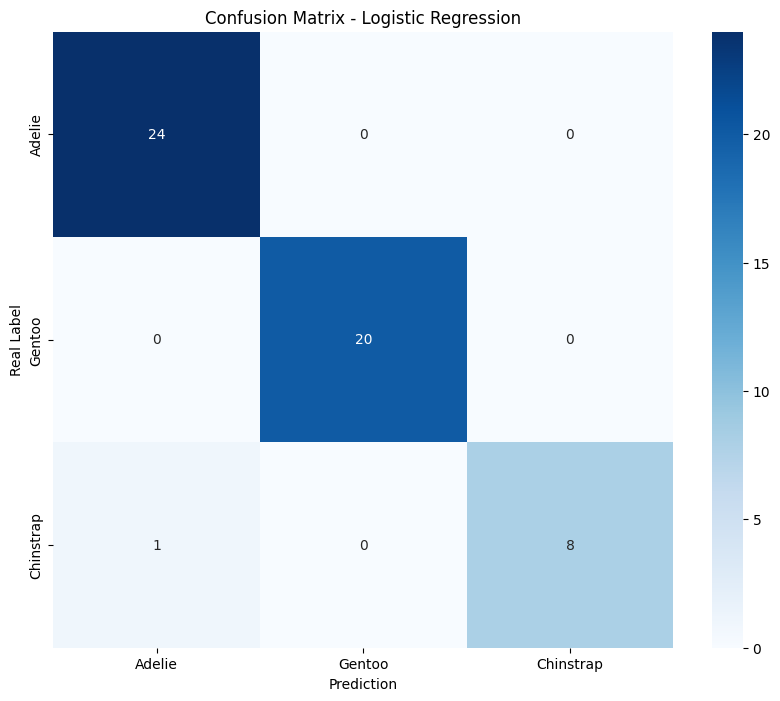

25/05/16 15:37:37 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1913526 ms exceeds timeout 120000 ms
25/05/16 15:37:38 WARN SparkContext: Killing executors is not supported by current scheduler.
25/05/16 15:37:38 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

labels = model.stages[0].labels 
conf_matrix_np = np.array(conf_matrix.toArray())

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_np, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Prediction')
plt.ylabel('Real Label')
plt.show()